# Setup 

In [7]:
import numpy as np


# class UCB1:
#     def __init__(self, num_arms: int, delta: float):
#         self.t = 0
#         self.num_arms = num_arms
#         self.true_rewards = [0.5] + [1 - (0.5 - delta)] * (num_arms - 1)
#         self.acc_regrets = []
        
#         self.counts = np.zeros(num_arms)  # Number of times each arm is played
#         self.values = np.zeros(num_arms)  # Total reward for each arm

#     def select_arm(self) -> int:
#         if self.t < self.num_arms:
#             # If not all arms have been played at least once, play the next sequential arm
#             arm = self.t
#         else:
#             ucb_values = self.values / self.counts
#             confidence_bounds = np.sqrt((2 * np.log2(self.t)) / (2 * self.counts))
#             ucb_values += confidence_bounds
#             arm = np.argmax(ucb_values)
            
#         return arm

#     def update(self, chosen_arm: int):
#         # Simulate the reward using Bernoulli distribution
#         reward = np.random.binomial(1, self.true_rewards[chosen_arm])
#         self.counts[chosen_arm] += 1
#         self.values[chosen_arm] += reward

#         # Calculate regret
#         best_possible_reward = max(self.true_rewards)
#         regret = best_possible_reward - self.true_rewards[chosen_arm]
        
#         acc_regret = self.acc_regrets[self.t-1] if self.t > 0 else 0
#         self.acc_regrets.append(acc_regret + regret)
#         self.t += 1

# class UCB1:
#     def __init__(self, num_arms: int, T: int, mab):
#         self.t = 0
#         self.num_arms = num_arms
#         self.counts = np.zeros((num_arms, T), dtype=int)  # Two-dimensional array for time-step wise counts
#         self.values = np.zeros((num_arms, T))  # Two-dimensional array for time-step wise values
#         self.T = T
#         self.acc_regrets = np.zeros(T)
#         self.mab = mab

#     def select_arm(self) -> int:
#         if self.t < self.num_arms:
#             # Play each arm once
#             return self.t
#         else:
#             success_count = self.values.sum(axis=1)
#             total_count = self.counts.sum(axis=1)
#             avg_reward = success_count / total_count
#             ucb_values = avg_reward + np.sqrt(np.log(self.t + 1) / (2 * total_count))
#             # Use randomized tie-breaking
#             return np.random.choice(np.flatnonzero(ucb_values == ucb_values.max()))
    
#     def update(self, chosen_arm: int):
#         reward, regret = self.mab.draw(chosen_arm)
        
#         self.counts[chosen_arm, self.t] = 1
#         self.values[chosen_arm, self.t] = reward
#         # Accumulate regret
#         self.acc_regrets[self.t] = regret if self.t == 0 else self.acc_regrets[self.t - 1] + regret
#         self.t += 1
        

In [8]:
class MAB:
    def __init__(self, probs):
        self.probs = probs

    #0 is a*, 1 is a
    def draw(self, a):
        return np.random.binomial(1, self.probs[a]), np.max(self.probs) - self.probs[a]
    
    
class Stochastic_UCB1:
    def __init__(self, n_arms, T):
        self.counts = np.zeros((n_arms, T)).astype(float)
        self.values = np.zeros((n_arms, T)).astype(float)
        self.n_arms = n_arms
        self.T = T

    def select_arm(self):
        success_count = self.values.sum(axis=1)
        total_count = self.counts.sum(axis=1)
        arm_dont_usage = np.where(total_count == 0)[0]
        if len(arm_dont_usage) > 0:
            return arm_dont_usage[0]
        
        avg_reward = success_count/total_count
        ucb = self.ucb(avg_reward, total_count)
        
        chosen_arm = np.random.choice(np.flatnonzero(ucb == ucb.max())) #randomize tie breaking
        return chosen_arm
    
    def reset(self):
        self.counts = np.zeros((self.n_arms, self.T)).astype(float)
        self.values = np.zeros((self.n_arms, self.T)).astype(float)

    def ucb(self, avg_reward, total_count):
        return avg_reward + np.sqrt(np.log(np.sum(total_count)) / total_count)

    def update(self, chosen_arm, reward, t):
        self.counts[chosen_arm, t] = 1.0
        self.values[chosen_arm, t] = float(reward)

    def train(self, mab):
        self.p_regret = np.zeros(self.T)
        self.reset()
        for t in range(self.T):
            arm = self.select_arm()
            reward, regret = mab.draw(arm)
            self.update(arm, reward, t)
            if t > 0:
                #accumulative regret
                self.p_regret[t] = regret + self.p_regret[t-1]
            else:
                self.p_regret[t] = regret
                
                
class Stochastic_EXP3():
    def __init__(self, nA, lr):
        self.nA = nA
        self.lr = lr
    
    def train(self, T, mab): #0: optimal arm
        self.p_regret = np.zeros(T)
        P = np.full(self.nA, 1 / self.nA)
        cum_loss = np.zeros(self.nA)
        expected_loss = 0
        loss_vector = np.zeros(self.nA)

        for t in range(T):
            expected_losses = mab.probs
            eta = self.lr.step()
            a_t = np.random.choice(self.nA, p=P)
            
            mab.draw(a_t)
            
            l_t = np.random.binomial(1, p=expected_losses[a_t])
            l_tilde_t = l_t / P[a_t]
            cum_loss[a_t] += l_tilde_t

            expected_loss += expected_losses[a_t]
            loss_vector += expected_losses

            self.p_regret[t] = expected_loss - np.min(loss_vector)
            min_cum_loss = cum_loss - np.min(cum_loss)
            exp = np.exp(-eta * min_cum_loss)
            P = exp / np.sum(exp) 

In [9]:
class LearningRate():
    def __init__(self, nA):
        self.nA = nA
        self._fn = lambda t: np.sqrt(np.log(self.nA) / (self.nA * t))
        self.t = 0
    
    def step(self):
        self.t += 1
        return self._fn(self.t)

class EXP3():
    def __init__(self, nA, delta, T):
        self.p_regret = np.zeros(T)
        self.nA = nA
        self.lr = LearningRate(nA)
        self.P = np.full(self.nA, 1 / self.nA)
        self.cum_loss = np.zeros(self.nA)
        self.t = 0
        self.expected_loss = 0
        self.loss_vector = np.zeros(self.nA)
        self.expected_losses = [0.5] + [0.5 - delta] * (nA - 1)
    
    def select_arm(self):
        return np.random.choice(self.nA, p=self.P)
    
    def update(self, a_t):
        eta = self.lr.step()
        l_t = np.random.binomial(1, p=self.expected_losses[a_t])
        l_tilde_t = l_t / self.P[a_t]
        self.cum_loss[a_t] += l_tilde_t

        self.expected_loss += self.expected_losses[a_t]
        self.loss_vector += self.expected_losses

        self.p_regret[self.t] = self.expected_loss - np.min(self.loss_vector)
        min_cum_loss = self.cum_loss - np.min(self.cum_loss)
        exp = np.exp(-eta * min_cum_loss)
        self.P = exp / np.sum(exp) 
        self.t += 1

In [14]:


class AdversarialBandit:
    def __init__(self, probs):
        self.probs = probs

    def draw(self, a):
        reward = np.random.binomial(1, self.probs[a])
        loss = np.max(self.probs) - self.probs[a]
        # Flip probs
        self.probs = np.roll(self.probs, 1)
        return reward, loss


deltas: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


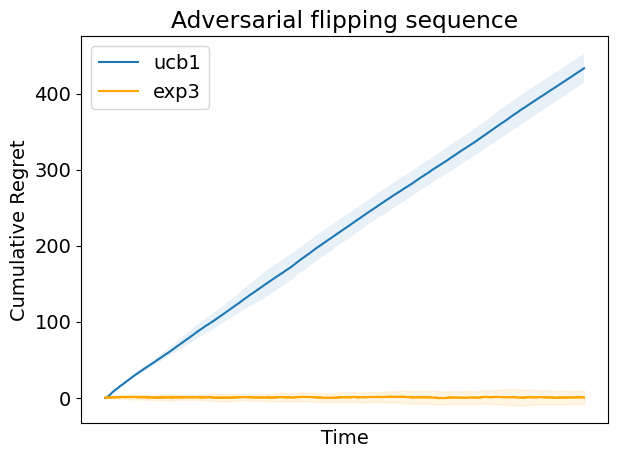

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # noqa: F811

plt.rcParams.update({'font.size': 14})

# Parameters
T = 1000# 00  # Total number of time steps
num_simulations = 20 # 20  # Number of simulations to run
K = [2]  # Number of arms
deltas = [1/4] # , 1/8, 1/16]  # Different values of delta

# Run simulations
for k in K:    
    #fig, axs = plt.subplots(1, len(deltas), figsize=(20, 8), sharey=True)
    # plt.suptitle(f'Performance Comparison for k = {k}', fontsize=24)
    for d, delta in tqdm(enumerate(deltas), desc='deltas', total=len(deltas)):
        results_ucb1 = []
        results_exp3 = []
        mab = AdversarialBandit([0.8, 0])
        for sim in tqdm(range(num_simulations), desc='simulations', total=num_simulations):
            # ucb1_instance = UCB1(k, T, MAB([0.5] + [1 - (0.5 - delta)] * (k - 1)))
            # exp3_instance = EXP3(k, delta, T)
            
            ucb1_stoch_instance = Stochastic_UCB1(k, T)
            exp3_stoch_instance = Stochastic_EXP3(k, LearningRate(k))
            
            # loss_mab = MAB([0.5] + [1 - (0.5 - delta)] * (k - 1))
            ucb1_stoch_instance.train(mab)
            # reward_mab = MAB([0.5] + [0.5 - delta] * (k - 1))
            exp3_stoch_instance.train(T, mab)        
            results_ucb1.append(ucb1_stoch_instance.p_regret)                
            results_exp3.append(exp3_stoch_instance.p_regret)

        # Calculate mean, min, max for ucb1 UCB1
        regrets_ucb1 = np.array(results_ucb1)
        mean_ucb1 = regrets_ucb1.mean(axis=0)
        std_ucb1 = regrets_ucb1.std(axis=0)

        # Calculate mean, min, max for exp3 UCB1
        regrets_exp3 = np.array(results_exp3)
        mean_exp3 = regrets_exp3.mean(axis=0)
        std_exp3 = regrets_exp3.std(axis=0)

        # Time steps
        time_steps = np.arange(T)

        # Plot ucb1
        plt.plot(time_steps, mean_ucb1, label='ucb1')
        plt.fill_between(time_steps, mean_ucb1 - std_ucb1, mean_ucb1 + std_ucb1, alpha=0.1)

        # Plot exp3
        plt.plot(time_steps, mean_exp3, label='exp3', color='orange')
        plt.fill_between(time_steps, mean_exp3 - std_exp3, mean_exp3 + std_exp3, color='orange', alpha=0.1)
        x = int(1/delta)
        plt.title('Adversarial flipping sequence')
        plt.xticks([])
        
    plt.ylabel('Cumulative Regret')
    plt.xlabel('Time')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'artifacts/adversarial_ucb1_performance_k{k}_0_8.pdf')
    plt.show()